# EdgeSHAPer Shapley Values convergence and variance study

In [1]:
import torch
from torchdrug import data
import pandas as pd
import numpy as np
import random

from rdkit import Chem
from rdkit.Chem import Draw
from pysmiles import read_smiles
import networkx as nx

from rdkit_heatmaps import mapvalues2mol
from rdkit_heatmaps.utils import transform2png
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
# for debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Reproducibility Settings

In [3]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

## Data Loading

In [4]:
DATASET_TYPE = "single" #"single", dual
TARGET = 1
TRAINING_SET_SPLIT = "FULL" #None, FULL, 0, 1, 2
MODEL_NUM = 0 #2 with single targe 1 vs random
SAVE = False
TARGET_CPDS = "P14416_P42336" #"P14416_P42336 (single) #P27338_P22303 P27338_P29274 Q9Y5N1_P31645 (dual)
DATASET_NAME = "chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" #"chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_" + TARGET_CPDS + "_target_"+ str(TARGET) +"_vs_random_cpds" # "chembl29_dt_cpds_" + TARGET_CPDS + "_balanced" #"chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds"
CSV_DATA_PATH = "../data/"+ DATASET_NAME + ".csv"

SELECTED_CPD = "Cc1ncsc1-c1nnc(SCCCN2CCC3(CC3c3ccc(C(F)(F)F)cc3)C2)n1C" #["C#Cc1ccc2sc(C(=O)NCCCCN3CCN(c4ccccc4OC)CC3)cc2c1", "Cc1ncsc1-c1nnc(SCCCN2CCC3(CC3c3ccc(C(F)(F)F)cc3)C2)n1C"] #[]

smiles_df = pd.read_csv(CSV_DATA_PATH, sep = ",")
display(smiles_df.head())
display(smiles_df.shape)

,nonstereo_aromatic_smiles,target_pair,label
0,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
1,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,P14416_P42336,0
2,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,P14416_P42336,0
3,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,P14416_P42336,0
4,Brc1cccc(N2CCN(Cc3cc4ccccn4n3)CC2)n1,P14416_P42336,0


(8348, 3)

## Define Custom Class
We need to define the ChEMBL datasets class in order to load the model

In [5]:
import os

from torchdrug.core import Registry as R
from torchdrug.utils import doc


@R.register("datasets.ChEMBL") #only first time you launch the class
#@doc.copy_args(data.MoleculeDataset.load_csv, ignore=("path", "smiles_field", "target_fields"))
class ChEMBL(data.MoleculeDataset):
    

    def __init__(self, path, smiles_field, target_fields, verbose=1, **kwargs):
        # path = os.path.expanduser(path)# if not os.path.exists(path):
        #     os.makedirs(path)
        self.path = path
        self.smiles_field = smiles_field
        self.target_fields= target_fields
        #print(self.path)
        # zip_file = utils.download(self.url, path, md5=self.md5)
        # csv_file = utils.extract(zip_file)

        self.load_csv(self.path, smiles_field=self.smiles_field, target_fields=self.target_fields,
                      verbose=verbose, **kwargs)

In [6]:
#target_fields = ["target1", "target2"] if DATASET_TYPE == "dual" else ["label"]
target_fields = ["label"]
chembl_dataset = ChEMBL(path = CSV_DATA_PATH, smiles_field = "nonstereo_aromatic_smiles", target_fields = target_fields)

Loading ../data/chembl29_predicting_target_P14416_P42336_target_1_vs_random_cpds.csv: 100%|██████████| 8349/8349 [00:00<00:00, 62009.37it/s]
Constructing molecules from SMILES:  54%|█████▍    | 4508/8348 [00:18<00:14, 271.59it/s]c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES: 100%|██████████| 8348/8348 [00:31<00:00, 262.98it/s]


## Obtain edge index to use with PyG

Visualize molecules using NetworkX

In [7]:
smiles = chembl_dataset.smiles_list
mols = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols.append(read_smiles(chembl_dataset.smiles_list[i]))

  0%|          | 0/8348 [00:00<?, ?it/s]

Define edge index 

In [8]:
edge_index_list = []

for mol in tqdm(mols):
    adj = nx.to_scipy_sparse_matrix(mol).tocoo()
    row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
    col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
    edge_index = torch.stack([row, col], dim=0)
    edge_index_list.append(edge_index)

display(len(mols))

  0%|          | 0/8348 [00:00<?, ?it/s]

8348

Define torchdrug dataset in order to get node features

In [9]:
mols_torchdrug_format = []
for i in tqdm(range(len(chembl_dataset.smiles_list))):
    mols_torchdrug_format.append(data.Molecule.from_smiles(chembl_dataset.smiles_list[i], with_hydrogen = False))


  0%|          | 0/8348 [00:00<?, ?it/s]

## Create Custom Dataset

In [10]:
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_list = []
y = torch.LongTensor(chembl_dataset.targets["label"]).to(device)

for i in tqdm(range(len(mols))):
    data_list.append(Data(x = mols_torchdrug_format[i].node_feature, edge_index = edge_index_list[i], y = y[i], smiles = chembl_dataset.smiles_list[i]))


  0%|          | 0/8348 [00:00<?, ?it/s]

In [11]:
class ChEMBLDatasetPyG(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, data_list = None):
        super().__init__(root, transform, pre_transform, pre_filter)
        #self.data, self.slices = torch.load(self.processed_paths[0])
        self.data_list = data_list

        # Read data into huge `Data` list.
        data_list = self.data_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.data, self.slices = self.collate(data_list)
        

In [12]:
dataset = ChEMBLDatasetPyG(".", data_list = data_list)

Split data in train/val/test (0.8/0.1/0.1)

In [13]:
lengths = [int(0.8 * len(chembl_dataset)), int(0.1 * len(chembl_dataset))]
lengths += [len(chembl_dataset) - sum(lengths)]

print(lengths)
dataset = dataset.shuffle()
train_data = dataset[:lengths[0]]
val_data = dataset[lengths[0]+1:lengths[0] + lengths[1]+1]
test_data = dataset[lengths[0] + lengths[1] + 1: ]  #we add +1 otherwise the last sample of the validation falls in the test too.
len(train_data), len(val_data), len(test_data)

[6678, 834, 836]


(6678, 834, 835)

In [14]:
batch_size= 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## GCN Definition

In [15]:
from torch_geometric.nn import GCNConv, Linear
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(chembl_dataset.node_feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=256).to(device)
print(model)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


## Load the Model

In [16]:
import os.path as osp

if TRAINING_SET_SPLIT == None:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_model_" + str(MODEL_NUM) + ".ckpt"
else:
    MODEL_PATH = "../models/PyG/" + DATASET_NAME + "_training_set_" + str(TRAINING_SET_SPLIT) + "_model_" + str(MODEL_NUM) + ".ckpt"
ckpt_path = osp.join(MODEL_PATH)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

GCN(
  (conv1): GCNConv(69, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (conv4): GCNConv(256, 256)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)

## Test the Model

In [17]:
def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

test_acc = test(test_loader)    
print(f'Test Acc: {test_acc:.4f}')



Test Acc: 0.9749


## GraphSHAPer

* Players = edges
* Value = predicted probability $v$
* $E$ = set of all edges
* $v(E)$ = value of all the edges == original predicted prob
* $\phi_m(v)$ = payout for the contribution of edge m
* $S$ = all the possible subset of edges excluding m
* |S| = size of S
* $v(S)$ is the value achieved by subset S
* $v(S∪{m})$ is the realized value after m joins S

Shapley values compouted as:

$\phi_m(v) = \frac{1}{|E|} \sum_S \frac{v(S \cup {m}) - v(S)}{\binom{|E|-1}{|S|}}$

### Find compound index in test set

In [18]:
#uncomment the below to choose by smile and not by index
for i in range(len(test_data)):
    if test_data[i].smiles == SELECTED_CPD:
        test_set_index =  i
        break

#uncomment the below to choose by index and not by smile
# test_set_index = 89 #112 #458 #89 #121

Cc1ncsc1-c1nnc(SCCCN2CCC3(CC3c3ccc(C(F)(F)F)cc3)C2)n1C
tensor([[ 11.9760, -11.6393]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[1.0000e+00, 5.5466e-11]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


c:\Users\Mastro\anaconda3\envs\graphshap_cheminfo\lib\site-packages\torchdrug\data\molecule.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

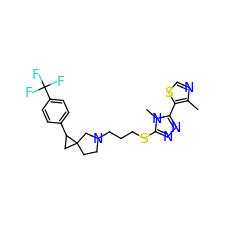

In [19]:
#test nums 78, 89, 2 is predicted to interact with target cpd, sample 0 is random for single target dataset with target 1. class 0 interacts, class 1 is random
# 78 is predicted to interact with target for dataset with target 2. 0 interacts with random
# for dual target Q9Y5N1_P31645 sample 0 has class 0
# for dual target P27338_P29274 sample 0 is class 0
# for dual targe P27338_P22303 sample 4 is class 0

#uncomment the below to choose by index and not by smile
# test_set_index = 89 #112 #458 #89 #121
#
test_cpd = test_data[test_set_index].to(device)

print(test_cpd.smiles)
mol_test = data.Molecule.from_smiles(test_cpd.smiles, with_hydrogen=False)
mol_test.visualize()

model.eval()
# all nodes belong to same graph
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob = F.softmax(out, dim = 1)
target_class = torch.argmax(out_prob[0]).item()
print(out)
print(out_prob)
target_class

Creating folder and saving smiles

In [20]:
# if SAVE:
    
#     if DATASET_TYPE == "dual":
#         FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS
#     else:
#         FOLDER_NAME = "../results/explanations/" + DATASET_TYPE + "/" + TARGET_CPDS +"/Target " + str(TARGET) + " vs Random"

#     CPD_FOLDER_NAME = FOLDER_NAME + "/" + test_cpd.smiles

#     if not os.path.exists(FOLDER_NAME):
#         os.mkdir(FOLDER_NAME)

#     if not os.path.exists(CPD_FOLDER_NAME):
#         os.mkdir(CPD_FOLDER_NAME)


#     mol_test.visualize(save_file = CPD_FOLDER_NAME + "/" + test_cpd.smiles + ".png")

# mol_test.visualize()

In [21]:
print(test_cpd.edge_index)
print(test_cpd.edge_index.shape)

tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,
          8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 14, 15, 15,
         16, 16, 17, 17, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 22, 22,
         23, 23, 23, 24, 24, 24, 24, 25, 26, 27, 28, 28, 29, 29, 30, 30, 31, 31,
         31, 32],
        [ 1,  0,  2,  5,  1,  3,  2,  4,  3,  5,  1,  4,  6,  5,  7, 31,  6,  8,
          7,  9,  8, 10, 31,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 30, 14, 16,
         15, 17, 16, 18, 19, 30, 17, 19, 17, 18, 20, 19, 21, 29, 20, 22, 21, 23,
         22, 24, 28, 23, 25, 26, 27, 24, 24, 24, 23, 29, 20, 28, 14, 17,  6,  9,
         32, 31]], device='cuda:0')
torch.Size([2, 74])


### Montecarlo Sampling

See https://christophm.github.io/interpretable-ml-book/shapley.html#estimating-the-shapley-value and https://link.springer.com/article/10.1007/s10115-013-0679-x

Inseatd of randmly sampling sample $z$ from the data (that for use is nonsense) we create a random graph $Z$ according to a problability distribution.
We add an edge according to the probability of an edge to exists in the explained graph G.

Pseudo code:

Output: Shapley value for j-th edge
Required: number of iterations M, graph to explain $G(N_g, E_g)$, edge list E, edge index j, edge_probability_distribution, GNN model

$\forall\space m \in {0,...,M-1}$

* create random graph $Z(N_z,E_z)$, where $N_z = N_g$ and with $E_z$ are such that $z \in E_z | e \sim \mathbf{P}$, where $\mathbf{P}$ is the probablity distrubution of an edge to exist. (can be domain-specific, depends on atoms!)
* Choose a random permutation $\pi$ of the egdes
* Order edges list $E_g$: $E_g^{\phi}: (e_0,...,e_j,...,e_{|E_g|-1})$
* Order edges list $E_z$: $E_z^{\phi}: (z_0,...,z_j,...,z_{|E_z|-1})$
* Constuct the two new edge lists:
    * With index $j: E_{+j} = (e_0,...,e_j,z_{j+1}...,z_{|E_z|-1})$
    * Without index $j: E_{-j} = (e_0,...,e_{j-1}, z_j,z_{j+1}...,z_{|E_z|-1})$
* Compute marginal contribution: $\phi_j^m = \hat{f}(E_{+j}) - \hat{f}(E_{+j})$
* Compute Shapley values as the avb: $\phi_j(G) = \frac{1}{M} \sum_{m=0}^{M-1} \phi_{j}^{m}$

where $\hat{f}$ is the function learned by the GNN

number of max edges in directed graph: n*(n-1)

number of max edges in undirected graph: (n*(n-1))/2

### Define edge probablility
We approximate it by using the graph desinity. This is a rather brutal approximation, a domain-specific approach would work probably better (e.g. atoms involved etc)

In [22]:
E = test_cpd.edge_index
num_nodes = test_cpd.x.shape[0]
max_num_edges = num_nodes*(num_nodes-1)
num_edges = E.shape[1]
graph_density = num_edges/max_num_edges
P = graph_density #this is to be discussed and mention in paper

In [23]:
M = 1000 #200
TOL = 10e-3
phi_edges = []
phi_sum_over_M = []
phi_edges_current = [0] * num_edges
sample_variances = []
variances = []
model.eval()
batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
out_prob_real = F.softmax(out, dim = 1)[0][target_class].item()

# marginal_contrib = 0
from numpy.random import default_rng
rng = default_rng(seed = 42) #to seed or not to seed?
model.eval()

log_odds = False
for i in tqdm(range(1, M+1)):
    
    for j in range(num_edges):
        #marginal_contrib = 0
        
        E_z_mask = rng.binomial(1, P, num_edges)
        #E_z_index = torch.IntTensor(torch.nonzero(torch.IntTensor(E_z_mask)).tolist()).to(device).squeeze()
        #E_z = torch.index_select(E, dim = 1, index = E_z_index)
        E_mask = torch.ones(num_edges)
        pi = torch.randperm(num_edges)

        E_j_plus_index = torch.ones(num_edges, dtype=torch.int)
        E_j_minus_index = torch.ones(num_edges, dtype=torch.int)
        selected_edge_index = np.where(pi == j)[0].item()
        for k in range(num_edges):
            if k <= selected_edge_index:
                E_j_plus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_plus_index[pi[k]] = E_z_mask[pi[k]]

        for k in range(num_edges):
            if k < selected_edge_index:
                E_j_minus_index[pi[k]] = E_mask[pi[k]]
            else:
                E_j_minus_index[pi[k]] = E_z_mask[pi[k]]


        #we compute marginal contribs
        
        # with edge j
        retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
        E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        
        out = model(test_cpd.x, E_j_plus, batch=batch)
        out_prob = None

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out #out prob variable now containts log_odds
        
        V_j_plus = out_prob[0][target_class].item() #probably the predicted class changes when selecting/deselecing certain edges for class 1: more iterations needed?

        # without edge j
        retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
        E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

        batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
        out = model(test_cpd.x, E_j_minus, batch=batch)

        if not log_odds:
            out_prob = F.softmax(out, dim = 1)
        else:
            out_prob = out
        
        V_j_minus = out_prob[0][target_class].item()

        phi_edges_current[j] += (V_j_plus - V_j_minus)

    #phi_edges.append(marginal_contrib/M)
    phi_edges = [elem / i for elem in phi_edges_current]
    print(sum(phi_edges))
    phi_sum_over_M.append(sum(phi_edges))
    sample_variances.append(np.var(phi_sum_over_M))
    sum_squared = sum([(sum_of_phi - out_prob_real)**2 for sum_of_phi in phi_sum_over_M])
    variances.append(sum_squared/i)
    # if abs(out_prob_real - sum(phi_edges)) <= TOL:
    #     break     

print("Sampling steps before convergence: ", i)         
print("Sum of Shapley values: ", sum(phi_edges))
print("Predicted prob: ", out_prob_real)
print("Variances", sample_variances)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.5651886357604656
1.1410839778850266
1.4728685635713226
1.368375345257682
1.3323485100811996
1.4906985550536478
1.441113121239984
1.5790186734592242
1.560556802952041
1.5797363522688408
1.6732830305815383
1.6989197871404527
1.6432521202433377
1.5255320918619633
1.524086358619229
1.4295865190099613
1.426370163539841
1.4266412077899913
1.3948729298404166
1.437116399318631
1.5234018241120304
1.549353189932396
1.591176286195932
1.5297299573335856
1.439148164310521
1.5588712265452762
1.552545239280769
1.5502485970693547
1.58415770541264
1.6326847114234113
1.6133863246945404
1.6250965559749069
1.5902472398786451
1.5663834762134703
1.5665501008450182
1.5398959412031883
1.530077733861871
1.5288608959932648
1.563615396753529
1.5236580510472941
1.4754374238317984
1.4390247584018663
1.4200441650528783
1.4081022816365698
1.4204326411317192
1.3754829411982232
1.3810945353449817
1.3742641708679944
1.3638699967601609
1.361206105736571
1.3346715077951476
1.3274290095249837
1.3025184195194455
1.295320

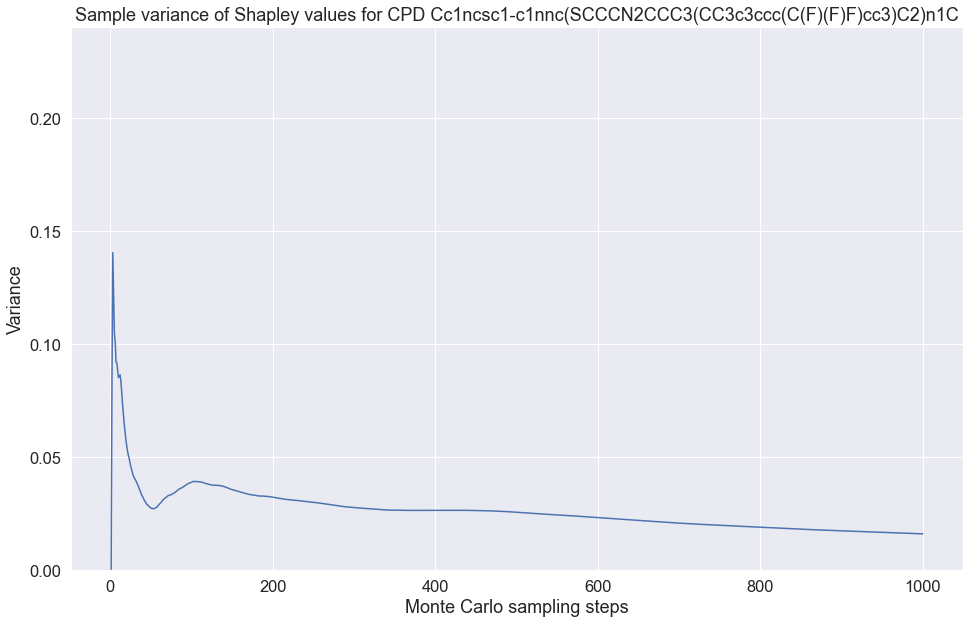

In [24]:
VARIANCE_FOLDER = "../results/variance_convergence_study/" + test_cpd.smiles + "/"
if not os.path.exists(VARIANCE_FOLDER):
    os.makedirs(VARIANCE_FOLDER)

figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=sample_variances)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Variance")
plt.title("Sample variance of Shapley values for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(sample_variances)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "sample_variance_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

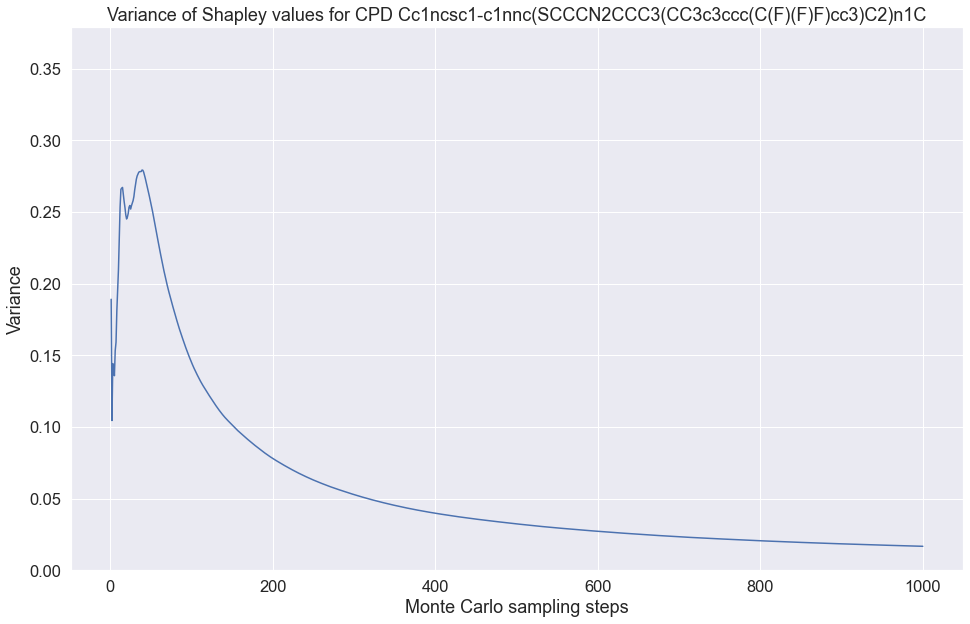

In [25]:
figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=variances)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Variance")
plt.title("Variance of Shapley values for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(variances)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "variance_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

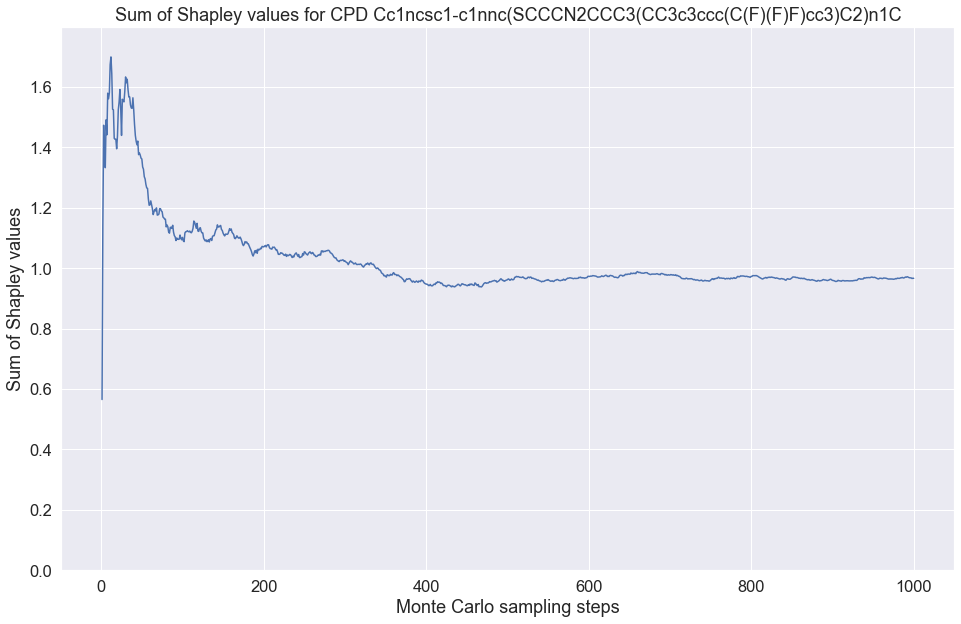

In [26]:
figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=phi_sum_over_M)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("Sum of Shapley values")
plt.title("Sum of Shapley values for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(phi_sum_over_M)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "sum_of_shapley_values_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

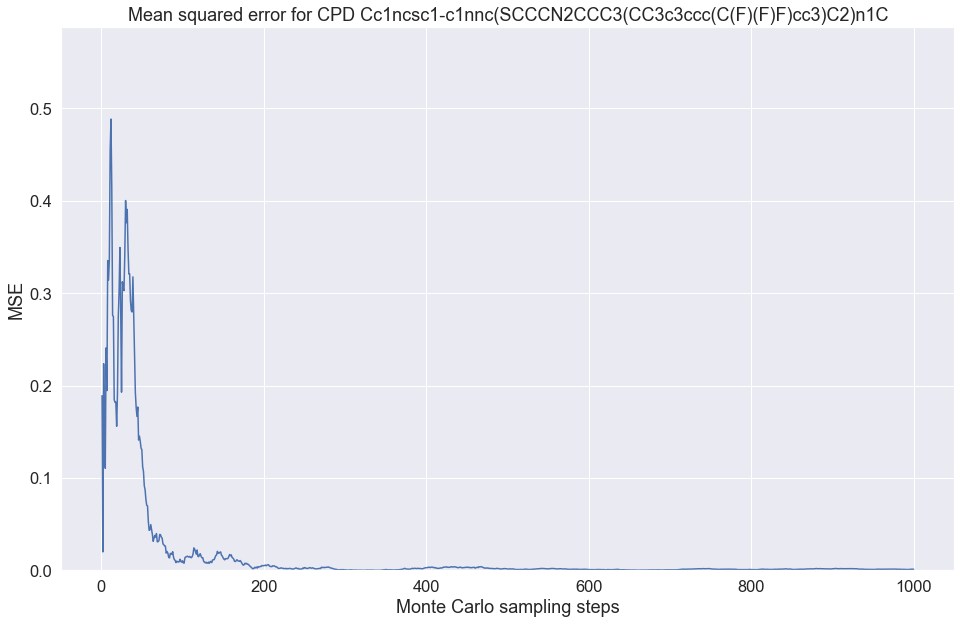

In [27]:
mse = [(out_prob_real - sum_of_phi)**2 for sum_of_phi in phi_sum_over_M]

figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=mse)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("MSE")
plt.title("Mean squared error for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(mse)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "mse_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

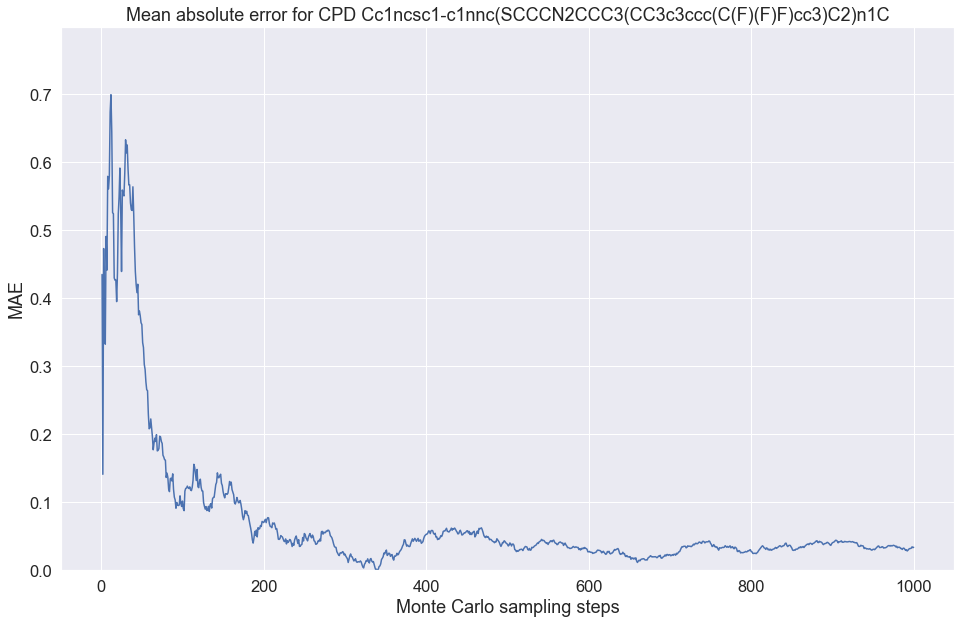

In [28]:
mae = [np.abs(out_prob_real - sum_of_phi) for sum_of_phi in phi_sum_over_M]

figure(figsize=(16, 10))
sns.set(font_scale=1.5)

sns.lineplot(x=range(1, M+1), y=mae)

plt.xlabel("Monte Carlo sampling steps")
plt.ylabel("MAE")
plt.title("Mean absolute error for CPD " + str(test_cpd.smiles))
plt.ylim(0, max(mae)+0.1)
# plt.xticks(ratios)
# plt.yticks(precision_folds)
plt.savefig(VARIANCE_FOLDER + "mae_sampling_steps_" + str(M) + ".png")
plt.show()
# plt.clf()

In [29]:
with open(VARIANCE_FOLDER + "sum_of_phis_over_M_sampling_steps_" + str(M) + ".txt", "w+") as saveFile:
         saveFile.write(str(phi_sum_over_M))

In [30]:
phi_sum_over_M

[0.5651886357604656,
 1.1410839778850266,
 1.4728685635713226,
 1.368375345257682,
 1.3323485100811996,
 1.4906985550536478,
 1.441113121239984,
 1.5790186734592242,
 1.560556802952041,
 1.5797363522688408,
 1.6732830305815383,
 1.6989197871404527,
 1.6432521202433377,
 1.5255320918619633,
 1.524086358619229,
 1.4295865190099613,
 1.426370163539841,
 1.4266412077899913,
 1.3948729298404166,
 1.437116399318631,
 1.5234018241120304,
 1.549353189932396,
 1.591176286195932,
 1.5297299573335856,
 1.439148164310521,
 1.5588712265452762,
 1.552545239280769,
 1.5502485970693547,
 1.58415770541264,
 1.6326847114234113,
 1.6133863246945404,
 1.6250965559749069,
 1.5902472398786451,
 1.5663834762134703,
 1.5665501008450182,
 1.5398959412031883,
 1.530077733861871,
 1.5288608959932648,
 1.563615396753529,
 1.5236580510472941,
 1.4754374238317984,
 1.4390247584018663,
 1.4200441650528783,
 1.4081022816365698,
 1.4204326411317192,
 1.3754829411982232,
 1.3810945353449817,
 1.3742641708679944,
 1.363

In [31]:
abs(out_prob_real - sum(phi_edges))

0.03383734888524659

In [32]:
print(out_prob)
print(phi_edges)

tensor([[1.8294e-10, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[-0.012999665606115247, -0.0032771526770756514, 0.009364720534304302, 7.847077382472631e-05, -0.021838569097215682, -0.0162658875269141, 0.00524722486414981, 0.008151620978946159, -0.008444934264718477, -0.009157278946790927, 0.004397558014311671, 0.020934808744648852, 0.0012407046613922862, 0.004866934766893216, -0.031057569424139782, 0.0035212283079572504, 0.02072290460873734, -0.00974925048623658, 0.007060738156450284, 0.03778136263601915, -0.030929316433174984, 0.07698021986154435, 0.0008415557108931343, 0.024332146878899355, -0.05542127378009978, 0.027275665549756554, -0.01905074881110212, 0.04908435992400217, 0.03683480547341508, 0.04427952103989926, 0.07326474851171776, 0.03776855679153452, 0.15588975653330195, 0.08727240095824357, 0.016377784441571463, 0.036917074453304465, 0.021571065645413674, -0.01335043473437341, 0.07814003808859295, 0.007976800660776415, -0.010648556567987608, 0.014336996702820

In [33]:
# if SAVE:
#     INFO_EXPLANATIONS = "info_explanations"
#     if TRAINING_SET_SPLIT != None:
#         INFO_EXPLANATIONS += "_training_split_" + str(TRAINING_SET_SPLIT)
        
#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "w+") as saveFile:
#         saveFile.write("Test set index: " + str(test_set_index) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Target Class: " + str(target_class) + "\n\n")

#     tagert_compound_sample = "TARGET" if target_class == 0 else "RANDOM"

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Target compound: " + str(tagert_compound_sample) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Sum of Shapley Values: " + str(sum(phi_edges)) + "\n\n")

#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("Shapley values:\n")
#         for phi_val in phi_edges:
#             saveFile.write(str(phi_val) + "\n")
#     with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("\nEdge Index:\n")
#         saveFile.write(str(test_cpd.edge_index) + "\n\n")
#         saveFile.write("Edge index shape: " + str(test_cpd.edge_index.shape) +"\n")

In [34]:
# retained_indices_plus = torch.LongTensor(torch.nonzero(E_j_plus_index).tolist()).to(device).squeeze()
# E_j_plus = torch.index_select(E, dim = 1, index = retained_indices_plus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_plus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_plus = out_prob[0][0].item()

# # without edge j
# retained_indices_minus = torch.LongTensor(torch.nonzero(E_j_minus_index).tolist()).to(device).squeeze()
# E_j_minus = torch.index_select(E, dim = 1, index = retained_indices_minus)

# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, E_j_minus, batch=batch)
# out_prob = F.softmax(out, dim = 1)

# V_j_minus = out_prob[0][0].item()

# marginal_contrib += (V_j_plus - V_j_minus)

In [35]:
# batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
# out = model(test_cpd.x, test_cpd.edge_index, batch=batch)
# out_prob = F.softmax(out, dim = 1)

## Visualize Explanation

In [36]:
# from matplotlib.pyplot import figure
# import matplotlib.pyplot as plt

# important_edges_ranking = np.argsort(-np.array(phi_edges))
# print(important_edges_ranking)
# sorted_phi_edges = sorted(phi_edges, reverse = True)
# print(sorted_phi_edges)
# print(sum(phi_edges))

# threshold = np.median(phi_edges) #to discuss when an edge in important or not
# hard_edge_mask = (torch.FloatTensor(phi_edges) > threshold).to(torch.float) #>=
# print(hard_edge_mask.shape)

# important_edges_index = torch.nonzero(hard_edge_mask == 1)
# print(important_edges_index)

# edge_index = E.to(device)
# important_edges_index = important_edges_index.to(device)

# important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
# print(important_edges)

# edges_color = []
# mol = read_smiles(test_cpd.smiles)

# #standard visualization for importan egdes GNNExplainer-like
# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     elif found_from or found_to:
#         edges_color.append("orange")
#     else:
#         edges_color.append("black")   

# #visualization for indentifying unimportant edges (edge is important if both directins are above threshold)
# # for edge in mol.edges:
# #     found_from = False
# #     found_to = False
# #     for i in range(important_edges.shape[1]):
# #         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
# #             found_from = True
# #         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
# #             found_to = True
# #     if found_from and found_to:
# #         edges_color.append("red")
# #     # elif found_from or found_to:
# #     #     edges_color.append("red")
# #     else:
# #         edges_color.append("black")   

# figure(figsize=(16, 12), dpi=80)
# #mol = nx.DiGraph(mol)
# labels = nx.get_node_attributes(mol, 'element') 
# nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

# # if SAVE:
# #     if TRAINING_SET_SPLIT == None:
# #         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M), dpi=300, bbox_inches='tight')
# #     else:
# #         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')
    
# # plt.show()

## Visualize Explanation - Moleculized

In [37]:
# test_mol = Chem.MolFromSmiles(test_cpd.smiles)
# test_mol = Draw.PrepareMolForDrawing(test_mol)

# num_bonds = len(test_mol.GetBonds())
# num_atoms = len(test_mol.GetAtoms())

# rdkit_bonds = {}

# for i in range(num_bonds):
#     init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
#     end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
#     bond_type = test_mol.GetBondWithIdx(i).GetBondType()
#     #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
#     rdkit_bonds[(init_atom, end_atom)] = i

# rdkit_bonds_phi = [0]*num_bonds
# for i in range(len(phi_edges)):
#     phi_value = phi_edges[i]
#     init_atom = edge_index[0][i].item()
#     end_atom = edge_index[1][i].item()
    
#     if (init_atom, end_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(init_atom, end_atom)]
#         rdkit_bonds_phi[bond_index] += phi_value
#     if (end_atom, init_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(end_atom, init_atom)]
#         rdkit_bonds_phi[bond_index] += phi_value

# plt.clf()
# canvas = mapvalues2mol(test_mol, None, rdkit_bonds_phi, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
# img = transform2png(canvas.GetDrawingText())

# # if SAVE:
# #     if TRAINING_SET_SPLIT == None:
# #         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "_heatmap.png")
# #     else:
# #         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GraphSHAPer_MC_" + str(M) + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
# img

## GNNExplainer
Explain the classification of a test cpd using GNNExplainer

In [38]:
# import os.path as osp

# import torch
# import torch.nn.functional as F


# from torch_geometric.nn import GNNExplainer

# torch.manual_seed(42)
# epochs = 100
# # test_cpd = test_data[0].to(device)

# #model = Net().to(device)

# #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# x, edge_index, edge_weight = test_cpd.x, test_cpd.edge_index, None

# explainer = GNNExplainer(model, epochs=epochs, return_type='log_prob')

# node_feat_mask, edge_mask = explainer.explain_graph(x, edge_index)

### Plot Explaination Subgraph

In [39]:
# from matplotlib.pyplot import figure

# figure(figsize=(16, 12), dpi=80)
# threshold = 0.75
# edge_mask = edge_mask.to("cpu")
# ax, G = explainer.visualize_subgraph(edge_index = edge_index, edge_mask = edge_mask, node_idx = -1, y=None, threshold=threshold)

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0", dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz0_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight')

# plt.show()

In [40]:
# hard_edge_mask = (edge_mask >= threshold).to(torch.float)
# hard_edge_mask.shape

# important_edges_index = torch.nonzero(hard_edge_mask == 1)
# print(important_edges_index)

# edge_index = edge_index.to(device)
# important_edges_index = important_edges_index.to(device)

# important_edges = torch.index_select(edge_index, dim = 1, index = important_edges_index.squeeze())
# print(important_edges)

# edges_color = []
# mol = read_smiles(test_cpd.smiles)

# for edge in mol.edges:
#     found_from = False
#     found_to = False
#     for i in range(important_edges.shape[1]):
#         if edge[0] == important_edges[0][i] and edge[1] == important_edges[1][i]:
#             found_from = True
#         if edge[1] == important_edges[0][i] and edge[0] == important_edges[1][i]:
#             found_to = True
#     if found_from and found_to:
#         edges_color.append("red")
#     elif found_from or found_to:
#         edges_color.append("orange")
#     else:
#         edges_color.append("black")   

# figure(figsize=(16, 12), dpi=80)
# #mol = nx.DiGraph(mol)
# labels = nx.get_node_attributes(mol, 'element') 
# nx.draw(mol, with_labels = True, edge_color = edges_color, pos=nx.spring_layout(mol))

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1", dpi=300, bbox_inches='tight')
#     else:
#         plt.savefig(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_viz1_" + "training_split_" + str(TRAINING_SET_SPLIT), dpi=300, bbox_inches='tight') 

# plt.show()

In [41]:
# # test_mol = Chem.MolFromSmiles(test_cpd.smiles)
# # test_mol = Draw.PrepareMolForDrawing(test_mol)

# # num_bonds = len(test_mol.GetBonds())
# # num_atoms = len(test_mol.GetAtoms())

# # rdkit_bonds = {}

# # for i in range(num_bonds):
# #     init_atom = test_mol.GetBondWithIdx(i).GetBeginAtomIdx()
# #     end_atom = test_mol.GetBondWithIdx(i).GetEndAtomIdx()
# #     bond_type = test_mol.GetBondWithIdx(i).GetBondType()
# #     #print("Bond: ", i, " " , init_atom, "-" , end_atom, " ", bond_type)
# #     rdkit_bonds[(init_atom, end_atom)] = i

# rdkit_bonds_GNNExpl_importance = [0]*num_bonds
# for i in range(len(edge_mask)):
#     GNNExpl_importance_value = edge_mask[i]
#     init_atom = edge_index[0][i].item()
#     end_atom = edge_index[1][i].item()
    
#     if (init_atom, end_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(init_atom, end_atom)]
#         rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()
#     if (end_atom, init_atom) in rdkit_bonds:
#         bond_index = rdkit_bonds[(end_atom, init_atom)]
#         rdkit_bonds_GNNExpl_importance[bond_index] += GNNExpl_importance_value.item()

# plt.clf()
# canvas = mapvalues2mol(test_mol, None, rdkit_bonds_GNNExpl_importance, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?
# img = transform2png(canvas.GetDrawingText())

# if SAVE:
#     if TRAINING_SET_SPLIT == None:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "heatmap.png")
#     else:
#         img.save(CPD_FOLDER_NAME + "/" + test_cpd.smiles + "_GEx_" + "training_split_" + str(TRAINING_SET_SPLIT) + "_heatmap.png") 
# img

## Pertinent Positive/Negative Set

### pertinent negative

In [42]:
# pertinent_set_indices = []
# pertinent_set_edge_index = None
# edge_index = E.to(device)
# print("Complete graph predicts class: ", target_class)

# model.eval()
# for i in range(important_edges_ranking.shape[0]):
#     index_of_edge_to_remove = important_edges_ranking[i]
#     pertinent_set_indices.append(index_of_edge_to_remove)

#     reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[i:]).to(device))
    
#     # all nodes belong to same graph
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, reduced_edge_index, batch=batch)
#     out_prob = F.softmax(out, dim = 1)
#     print(out_prob)
#     predicted_class = torch.argmax(out_prob[0]).item()

#     if predicted_class != target_class:
#         break

# pertinent_set_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(pertinent_set_indices).to(device))
# print(pertinent_set_indices)
# print(pertinent_set_edge_index)

# with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#         saveFile.write("\nPertinent Negative Set:\n")
#         saveFile.write("Pertinent set indices on edge ranking: " + str(pertinent_set_indices))
#         saveFile.write("\nPertinent set edge index: " + str(pertinent_set_edge_index))

### pertinent positive

In [43]:
# for i in range(important_edges_ranking.shape[0]+1):
#     reduced_edge_index = torch.index_select(edge_index, dim = 1, index = torch.LongTensor(important_edges_ranking[0:i]).to(device))
#     batch = torch.zeros(test_cpd.x.shape[0], dtype=int, device=test_cpd.x.device)
#     out = model(test_cpd.x, reduced_edge_index, batch=batch)
#     out_prob = F.softmax(out, dim = 1)
#     # print(out_prob)
#     predicted_class = torch.argmax(out_prob[0]).item()
#     if (predicted_class == target_class):
#         print(i)
#         print(reduced_edge_index)
#         print(out_prob)
#         with open(CPD_FOLDER_NAME + "/" + INFO_EXPLANATIONS + ".txt", "a") as saveFile:
#             saveFile.write("\nPertinent Positive Set:\n")
#             saveFile.write("\nPertinent set edge index: " + str(reduced_edge_index))
#         break